In [1]:
import os
import glob

import numpy as np
import pandas as pd
import pylab as plt
import csv

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 15 17:29:29 2022
Run after "NPM_1preprocessing"
To align photometry data and TTLs generated with BPOD, logged with NI+Bonsai 
BPOD TTLs (designed by HH)
20/10'barcode': start with 0.020,then 0.010 * 1-20
1'go_cue': 0.001,      # Should be the shortest, otherwise will miss some really fast licks
2'choice_L': 0.002,    # Relatively time-sensitive, should be shorter
3'choice_R': 0.003,    # Relatively time-sensitive, should be shorter
4'choice_M': 0.004,    # Relatively time-sensitive, should be shorter
30'reward': 0.03,       # Not very time-sensitive
40'iti_start': 0.04     # Not very time-sensitive
maxlength = 41 (@1000Hz logging)
@author: Kenta M. Hagihara @SvobodaLab
"""

'\nCreated on Tue Mar 15 17:29:29 2022\nRun after "NPM_1preprocessing"\nTo align photometry data and TTLs generated with BPOD, logged with NI+Bonsai \nBPOD TTLs (designed by HH)\n20/10\'barcode\': start with 0.020,then 0.010 * 1-20\n1\'go_cue\': 0.001,      # Should be the shortest, otherwise will miss some really fast licks\n2\'choice_L\': 0.002,    # Relatively time-sensitive, should be shorter\n3\'choice_R\': 0.003,    # Relatively time-sensitive, should be shorter\n4\'choice_M\': 0.004,    # Relatively time-sensitive, should be shorter\n30\'reward\': 0.03,       # Not very time-sensitive\n40\'iti_start\': 0.04     # Not very time-sensitive\nmaxlength = 41 (@1000Hz logging)\n@author: Kenta M. Hagihara @SvobodaLab\n'

In [3]:
DATA_ROOT_DIR = '/home/po-chen/projects/foraging/nm/data/'
ANA_DIR = 'testdata_photometry_0727/'
ana_dir_path = os.path.join(DATA_ROOT_DIR, ANA_DIR)

NM_TRACES_DIR = 'result'
nm_traces_dir_path = os.path.join(ana_dir_path, NM_TRACES_DIR)

In [4]:
# load data
# AnalDir = r"C:\Users\kenta.hagihara\OneDrive - Allen Institute\Data\FIP\220817\KH_FB32"

trace_0 = np.load(os.path.join(nm_traces_dir_path, 'G1_dF_F.npy'))
trace_1 = np.load(os.path.join(nm_traces_dir_path, 'R1_dF_F.npy'))
trace_2 = np.load(os.path.join(nm_traces_dir_path, 'G2_dF_F.npy'))
trace_3 = np.load(os.path.join(nm_traces_dir_path, 'R2_dF_F.npy'))

traces = np.vstack((trace_0, trace_1, trace_2, trace_3))
traces = traces.T   # size0:time/size1:number of signals
print(f'nm traces: {traces.shape}')

GCaMP_dF_F = np.load(os.path.join(nm_traces_dir_path, 'G2_dF_F.npy'))
R_dF_F = np.load(os.path.join(nm_traces_dir_path, 'R2_dF_F.npy'))

TTL_signal = np.fromfile(glob.glob(os.path.join(ana_dir_path, 'TTL_20*'))[0])
print(f'TTL_signal shape: {TTL_signal.shape}')

file_TTLTS = glob.glob(os.path.join(ana_dir_path, 'TTL_TS*'))[0]
print(f'TTLTS fp: {file_TTLTS}')
# Timestamp for TTL    
with open(file_TTLTS) as f:
    reader = csv.reader(f)
    data_temp = np.array([row for row in reader])
    TTLts = data_temp[0: , :].astype(np.float32)
print(f'TTLts: {TTLts.shape}')


#%%
if glob.glob(os.path.join(ana_dir_path, 'TimeStamp_*')) != []:   # data from NPM
    file_TS = glob.glob(os.path.join(ana_dir_path, 'TimeStamp_*'))[0]
    with open(file_TS) as f:
        reader = csv.reader(f)
        data_temp = np.array([row for row in reader])
        PMts = data_temp[0:,:].astype(np.float32)
    PMts2 = PMts[0: len(PMts): int(np.round(len(PMts)/len(traces))), :]  # length of PMts2 must be the same as that of GCaMP_dF_F
    
else:  # data from FIP
    PMts = np.load(glob.glob(os.path.join(ana_dir_path, 'PMts.npy'))[0])
    PMts2 = np.vstack((PMts, np.arange(len(PMts)))).T

print(f'PMts: {PMts.shape}')
print(f'PMts2: {PMts2.shape}')

nm traces: (117680, 4)
TTL_signal shape: (17652000,)
TTLTS fp: /home/po-chen/projects/foraging/nm/data/testdata_photometry_0727/TTL_TS2022-07-26T09_54_20.csv
TTLts: (5884, 1)
PMts: (353040, 2)
PMts2: (117680, 2)


In [5]:
FLAG_NO_RAW_LICK = 0

#%%Sorting NIDAQ-AI channels
if (len(TTL_signal)/1000) / len(TTLts) == 1:
    #plt.figure()
    #plt.plot(TTLsignal)
    print("Num Analog Channel: 1")
    
elif (len(TTL_signal)/1000) / len(TTLts) == 2:  # this shouldn't happen, though...
    TTL_signal_2 = TTL_signal[1::2]
    TTL_signal = TTL_signal[0::2]
    #plt.figure()
    #plt.plot(TTLsignal)
    #plt.plot(TTLsignal2)
    print("Num Analog Channel: 2")
        
elif (len(TTL_signal)/1000) / len(TTLts) >= 3:
    TTL_signal_1 = TTL_signal[0::3]
    #plt.figure()
    #plt.plot(TTLsignal1,label='Events')
    
    if FLAG_NO_RAW_LICK == 0: 
        TTL_signal_2 = TTL_signal[1::3]
        TTL_signal_3 = TTL_signal[2::3]
        #plt.plot(TTLsignal2,label='LickL')
        #plt.plot(TTLsignal3,label='LickR')    
    
    #plt.legend()
    print("Num Analog Channel: 3")

else:
    print("Something is wrong with TimeStamps or Analog Recording...")

Num Analog Channel: 3


In [6]:
#%% binalize analog inputs
TTL_signal = TTL_signal_1
TTL_signal[TTL_signal < 3] = 0
TTL_signal[TTL_signal >= 3] = 1
TTL_signal_shift = np.roll(TTL_signal, 1)
diff = TTL_signal - TTL_signal_shift

# Sorting
TTL_p = []
TTL_l = []

for ii in range(len(TTL_signal)):
    if diff[ii] == 1:
        for jj in range(120):  # Max length:40
            if ii+jj > len(TTL_signal)-1:
                break
            
            if diff[ii+jj] == -1:
                TTL_p = np.append(TTL_p, ii) 
                TTL_l = np.append(TTL_l, jj)
                break

In [8]:
# binalize raw lick signals    
if 'TTL_signal_2' in locals():
    if FLAG_NO_RAW_LICK == 1:
        TTL_signal_2[:] = 0
        
    TTL_signal_2[TTL_signal_2 < 0.5] = 0
    TTL_signal_2[TTL_signal_2 >= 0.5] = 1
    TTL_signal_2_shift = np.roll(TTL_signal_2, 1)
    diff_2 = TTL_signal_2 - TTL_signal_2_shift
    
    TTL2_p = []
    for ii in range(len(TTL_signal_2)):
        if diff_2[ii] == 1:
            TTL2_p = np.append(TTL2_p, ii) 

            
if 'TTL_signal_3' in locals():
    if FLAG_NO_RAW_LICK == 1:
        TTL_signal_3[:] = 0
        
    TTL_signal_3[TTL_signal_3 < 0.5] = 0
    TTL_signal_3[TTL_signal_3 >= 0.5] = 1
    TTL_signal_3_shift = np.roll(TTL_signal_3, 1)
    diff_3 = TTL_signal_3 - TTL_signal_3_shift
    
    TTL3_p = []
    for ii in range(len(TTL_signal_3)):
        if diff_3[ii] == 1:
            TTL3_p = np.append(TTL3_p, ii)

In [9]:
#%% Alignment between PMT and TTL
TTL_p_align = []

for ii in range(len(TTL_p)):
    ind_tmp = int(np.ceil(TTL_p[ii]/1000)-2)  # consider NIDAQ buffer 1s (1000samples@1kHz)
    dec_tmp = TTL_p[ii]/1000 + 1 - np.ceil(TTL_p[ii]/1000)
    if ind_tmp >= len(TTLts):
        break
    ms_target = TTLts[ind_tmp]
    idx = int(np.argmin(np.abs(np.array(PMts2[:,0]) - ms_target - dec_tmp*1000)))
    TTL_p_align = np.append(TTL_p_align, idx)
    
TTL_l_align = TTL_l[0:len(TTL_p_align)] 


if 'TTL2_p' in locals():
    TTL2_p_align = []
    for ii in range(len(TTL2_p)):
        ind_tmp = int(np.ceil(TTL2_p[ii]/1000)-2)  # consider NIDAQ buffer 1s (1000samples@1kHz)
        dec_tmp = TTL2_p[ii]/1000 + 1 - np.ceil(TTL2_p[ii]/1000)
        if ind_tmp >= len(TTLts):
            break
        ms_target = TTLts[ind_tmp]
        idx = int(np.argmin(np.abs(np.array(PMts2[:,0]) - ms_target - dec_tmp*1000)))
        TTL2_p_align = np.append(TTL2_p_align, idx)
    
if 'TTL3_p' in locals():
    TTL3_p_align = []
    for ii in range(len(TTL3_p)):
        ind_tmp = int(np.ceil(TTL3_p[ii]/1000)-2)  # consider NIDAQ buffer 1s (1000samples@1kHz)
        dec_tmp = TTL3_p[ii]/1000 + 1 - np.ceil(TTL3_p[ii]/1000)
        if ind_tmp >= len(TTLts):
            break
        ms_target = TTLts[ind_tmp]
        idx = int(np.argmin(np.abs(np.array(PMts2[:,0]) - ms_target - dec_tmp*1000)))
        TTL3_p_align = np.append(TTL3_p_align, idx)

In [11]:
#%% Rewarded Unrewarded L/R trials

rewarded_L = []
unrewarded_L = []
rewarded_R = []
unrewarded_R = []

for ii in range(len(TTL_l_align)-1):
    if TTL_l_align[ii] == 2 and TTL_l_align[ii+1] == 30:  # 30:reward, #40: ITI start
        rewarded_L = np.append(rewarded_L, ii)
    if TTL_l_align[ii] == 2 and TTL_l_align[ii+1] == 40:
         unrewarded_L = np.append(unrewarded_L, ii)   
    if TTL_l_align[ii] == 3 and TTL_l_align[ii+1] == 30:
        rewarded_R = np.append(rewarded_R, ii)
    if TTL_l_align[ii] == 3 and TTL_l_align[ii+1] == 40:
        unrewarded_R = np.append(unrewarded_R, ii)

unrewarded = np.union1d(unrewarded_L, unrewarded_R)
rewarded = np.union1d(rewarded_L, rewarded_R)

ignored = []

for ii in range(len(TTL_l_align)-1):
    if TTL_l_align[ii] == 1 and TTL_l_align[ii+1] == 40:  # 1:GoCue, #40: ITI start
        ignored = np.append(ignored, ii)

In [12]:
#%% Barcode Decode (220626 updated)
barcode_P = TTL_p[TTL_l == 20]
barcode_bin = np.zeros((len(barcode_P),20))

for ii in range(len(barcode_P)):
    for jj in range(20):
        barcode_bin[ii,jj] = TTL_signal_1[int(barcode_P[ii])+30+20*jj+5] # checking the middle of 10ms windows

bar_char=[]

for ii in range(len(barcode_P)):
    temp = barcode_bin[ii].astype(int)
    temp2 = ''
    for jj in range(20):
        temp2 = temp2 + str(temp[jj])
    bar_char.append(temp2)
    del temp, temp2

Text(0.5, 1.0, 'Reaction Time')

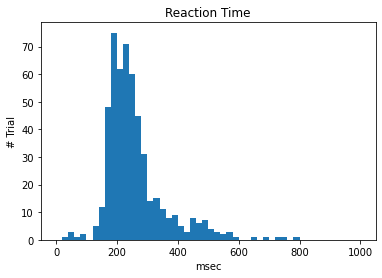

In [14]:
#%% ReactionTime
reaction_time_raw = []
for ii in range(len(TTL_l)-1):
    if TTL_l[ii] == 1 and (TTL_l[ii+1] == 3 or TTL_l[ii+1] == 2):
        reaction_time_raw = np.append(reaction_time_raw, TTL_p[ii+1] - TTL_p[ii])

plt.figure()
plt.xlabel("msec")
plt.ylabel("# Trial")
plt.hist(reaction_time_raw, 50,range=[0, 1000])
plt.title("Reaction Time")
# plt.savefig(AnalDir + os.sep + "Fig_ReactionTime.png")

## Behavioral & NM

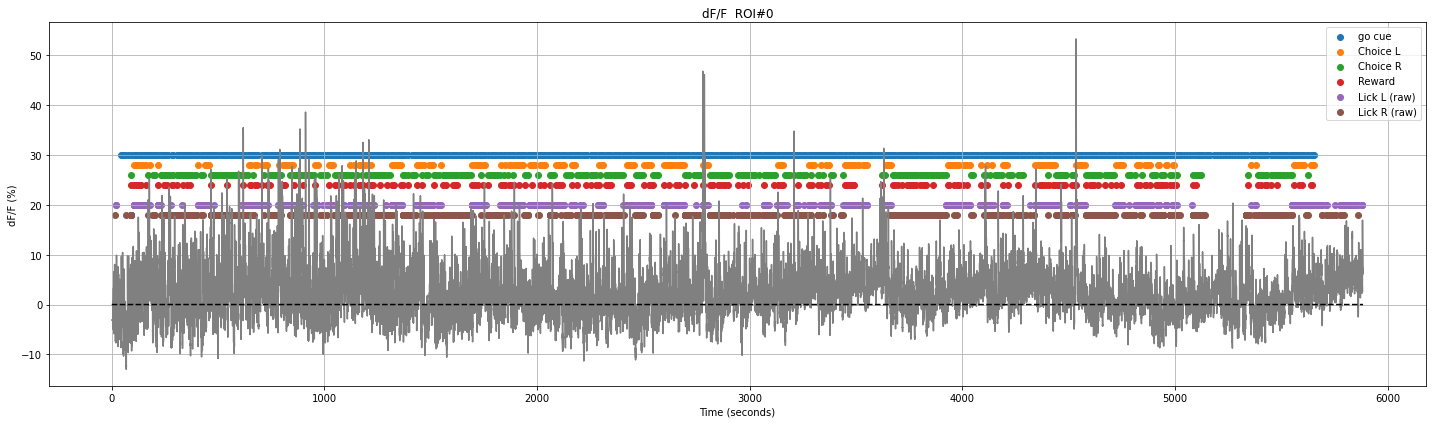

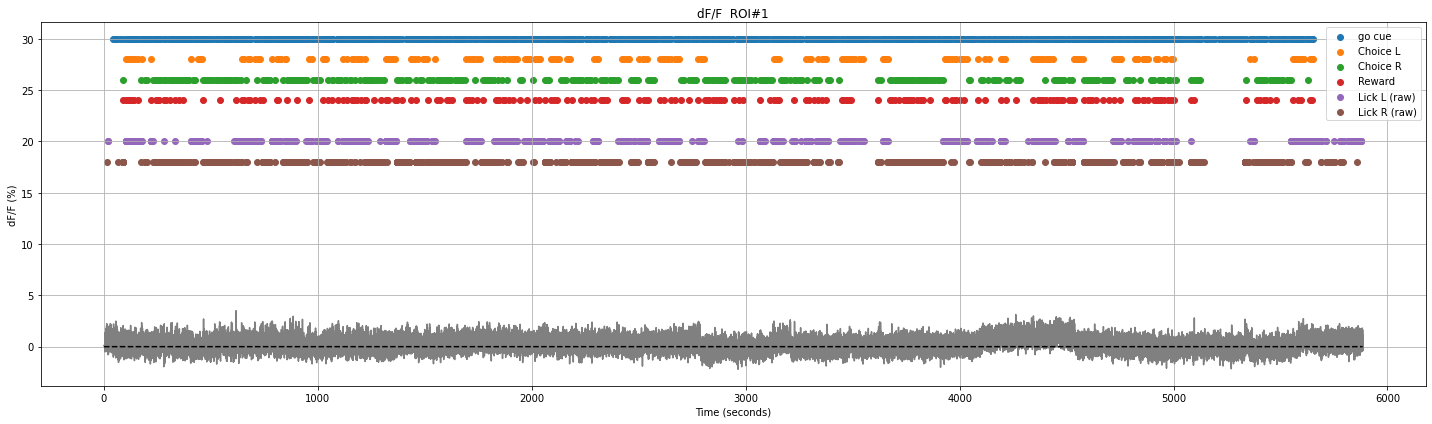

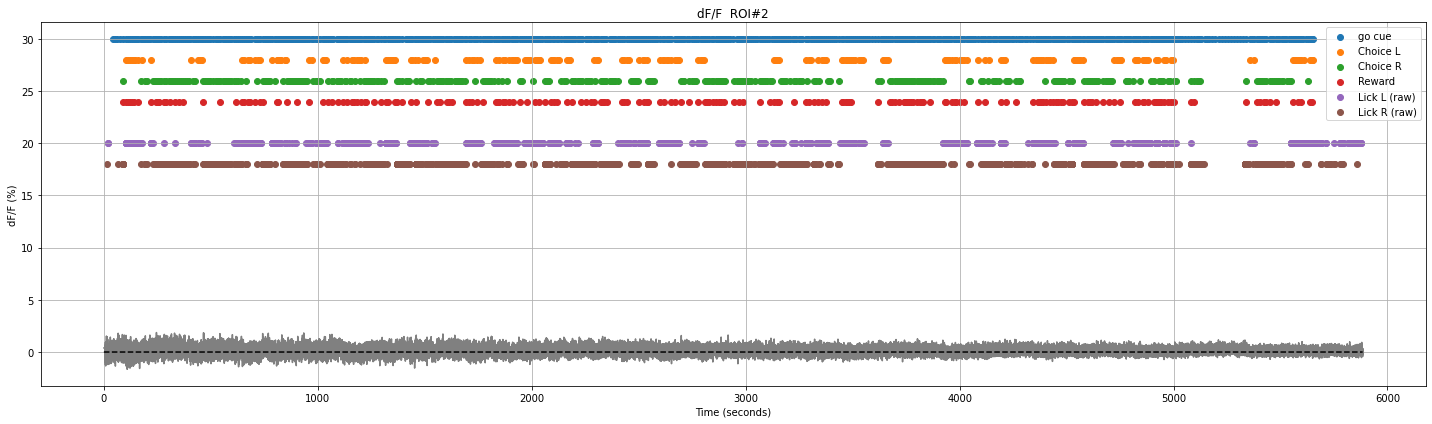

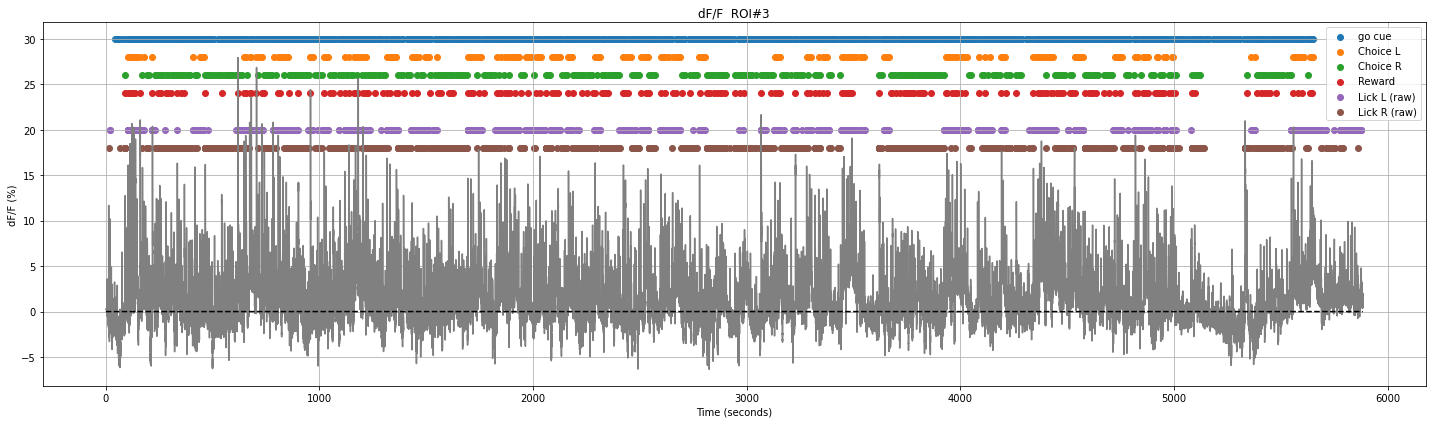

In [15]:
#%% Ca, Behavior Overview
time_seconds = np.arange(len(traces)) /20

## ToDo Multiplex for multiple channels!!!
for ii in range(np.size(traces,1)):
    plt.figure(figsize=(20, 6))
    plt.plot(time_seconds, traces[:, ii]*100, 'gray')    
    plt.plot(time_seconds, np.zeros(len(time_seconds)),'--k')   
    plt.xlabel('Time (seconds)')   
    plt.ylabel('dF/F (%)')   
    plt.title('dF/F  ROI#' + str(ii))  
    plt.grid(True)
    
    plt.scatter(TTL_p_align[TTL_l_align == 1]/20,np.ones(len(TTL_p_align[TTL_l_align == 1]))*30,label='go cue')  
    plt.scatter(TTL_p_align[TTL_l_align == 2]/20,np.ones(len(TTL_p_align[TTL_l_align == 2]))*28,label='Choice L')  
    plt.scatter(TTL_p_align[TTL_l_align == 3]/20,np.ones(len(TTL_p_align[TTL_l_align == 3]))*26,label='Choice R')  
    plt.scatter(TTL_p_align[TTL_l_align == 30]/20,np.ones(len(TTL_p_align[TTL_l_align == 30]))*24,label='Reward')  
    
    if 'TTL3_p' and 'TTL2_p' in locals():  
        plt.scatter(TTL2_p_align/20,np.ones(len(TTL2_p_align))*20,label='Lick L (raw)')  
        plt.scatter(TTL3_p_align/20,np.ones(len(TTL3_p_align))*18,label='Lick R (raw)')  
    
    plt.legend()
    plt.tight_layout()
    #plt.savefig(AnalDir + os.sep + "Fig_RawOverview_" + str(ii) + ".png")

In [ ]:
#%% PSTH functions
def PSTH_maker(TC, Stims, preW, postW):
    
    cnt = 0
    
    for ii in range(len(Stims)):
        if Stims[ii] - preW >= 0 and  Stims[ii] + postW < len(TC):
            
            A = int(Stims[ii]-preW) 
            B = int(Stims[ii]+postW)
            
            if cnt == 0:
                PSTHout = TC[A:B]
                cnt = 1
            else:
                PSTHout = np.vstack([PSTHout,TC[A:B]])
    
    return PSTHout


def PSTH_plot(PSTH, MainColor, SubColor, LabelStr):
    plt.plot(np.arange(np.shape(PSTH)[1])/20 - 5, np.mean(PSTH.T,axis=1),label=LabelStr,color = MainColor)
    plt.plot(np.arange(np.shape(PSTH)[1])/20 - 5, np.mean(PSTH.T,axis=1) + np.std(PSTH.T,axis=1)/np.sqrt(np.shape(PSTH)[0]),color = SubColor, linestyle = "dotted")
    plt.plot(np.arange(np.shape(PSTH)[1])/20 - 5, np.mean(PSTH.T,axis=1) - np.std(PSTH.T,axis=1)/np.sqrt(np.shape(PSTH)[0]),color = SubColor, linestyle = "dotted")



#%% Ploting Loop
for ii in range(np.size(Traces,1)):
    
    Trace_this = Traces[:,ii]

    PSTH_Rewarded = PSTHmaker(Trace_this*100, TTL_p_align[Rewarded.astype(int)], 100, 200)
    PSTH_RewardedL = PSTHmaker(Trace_this*100, TTL_p_align[RewardedL.astype(int)], 100, 200)
    PSTH_RewardedR = PSTHmaker(Trace_this*100, TTL_p_align[RewardedR.astype(int)], 100, 200)

    PSTH_UnRewarded = PSTHmaker(Trace_this*100, TTL_p_align[UnRewarded.astype(int)], 100, 200)
    PSTH_UnRewardedL = PSTHmaker(Trace_this*100, TTL_p_align[UnRewardedL.astype(int)], 100, 200)
    PSTH_UnRewardedR = PSTHmaker(Trace_this*100, TTL_p_align[UnRewardedR.astype(int)], 100, 200)

    PSTH_CueRewarded = PSTHmaker(Trace_this*100, TTL_p_align[Rewarded.astype(int)-1], 100, 200)
    PSTH_CueRewardedL = PSTHmaker(Trace_this*100, TTL_p_align[RewardedL.astype(int)-1], 100, 200)
    PSTH_CueRewardedR = PSTHmaker(Trace_this*100, TTL_p_align[RewardedR.astype(int)-1], 100, 200)

    PSTH_CueUnRewarded = PSTHmaker(Trace_this*100, TTL_p_align[UnRewarded.astype(int)-1], 100, 200)
    PSTH_CueUnRewardedL = PSTHmaker(Trace_this*100, TTL_p_align[UnRewardedL.astype(int)-1], 100, 200)
    PSTH_CueUnRewardedR = PSTHmaker(Trace_this*100, TTL_p_align[UnRewardedR.astype(int)-1], 100, 200)

    PSTH_Ignored = PSTHmaker(Trace_this*100, TTL_p_align[Ignored.astype(int)], 100, 200) #Cue aligned
 
    #Plotting

    fig=plt.figure(figsize=(12, 8))
    fig.canvas.set_window_title('Choice_Triggered  ROI#' + str(ii))
    plt.subplot(2,3,1)
    PSTHplot(PSTH_Rewarded, "b", "darkblue", "RewardedTrials")
    PSTHplot(PSTH_UnRewarded, "r", "darkred", "UnRewardedTrials")
    ymax = np.max([np.max(np.mean(PSTH_Rewarded,axis=0))+1,5]) 
    plt.ylim([-1,ymax])
    plt.xlim([-5,10])
    plt.legend()
    plt.grid(True)
    plt.title("ChoiceTriggered")
    plt.xlabel('Time (seconds)')
    plt.ylabel('dF/F (%)')

    #%
    plt.subplot(2,3,2)
    PSTHplot(PSTH_RewardedL, "b", "darkblue", "RewardedTrials")
    PSTHplot(PSTH_UnRewardedL, "r", "darkred", "UnRewardedTrials")
    ymax = np.max([np.max(np.mean(PSTH_Rewarded,axis=0))+1,5]) 
    plt.ylim([-1,ymax])
    plt.xlim([-5,10])
    plt.legend()
    plt.grid(True)
    plt.title("L-ChoiceTriggered")
    plt.xlabel('Time (seconds)')
    plt.ylabel('dF/F (%)')

    #%
    plt.subplot(2,3,3)
    PSTHplot(PSTH_RewardedR, "b", "darkblue", "RewardedTrials")
    PSTHplot(PSTH_UnRewardedR, "r", "darkred", "UnRewardedTrials")
    ymax = np.max([np.max(np.mean(PSTH_Rewarded,axis=0))+1,5]) 
    plt.ylim([-1,ymax])
    plt.xlim([-5,10])
    plt.legend()
    plt.grid(True)
    plt.title("R-ChoiceTriggered")
    plt.xlabel('Time (seconds)')
    plt.ylabel('dF/F (%)')


    #% Color map
    plt.subplot(2,3,4)
    plt.imshow(PSTH_Rewarded,vmin=-1,vmax=ymax)
    plt.xticks(ticks=[0, 50, 100,150,200,250,300], labels=['-5', '-2.5','0','2.5','5','7.5','10'])
    plt.xlabel('sec from choice')
    plt.ylabel('trials')
    plt.colorbar(shrink=0.5)
    plt.axvline(x=100,color='white',linestyle='--')
    plt.title("ChoiceTriggered_Rewarded")

    plt.subplot(2,3,5)
    plt.imshow(PSTH_UnRewarded,vmin=-1,vmax=ymax)
    plt.xticks(ticks=[0, 50, 100,150,200,250,300], labels=['-5', '-2.5','0','2.5','5','7.5','10'])
    plt.xlabel('sec from choice')
    plt.ylabel('trials')
    plt.colorbar(shrink=0.5)
    plt.axvline(x=100,color='white',linestyle='--')
    plt.title("ChoiceTriggered_UnRewarded")
    plt.savefig(AnalDir + os.sep + "Fig_PSTH_Choice" + str(ii) + ".png")

    #%  Cue Triggered Plotting
    fig=plt.figure(figsize=(12, 8))
    fig.canvas.set_window_title('Cue_Triggered  ROI#' + str(ii))
    plt.subplot(2,3,1)
    PSTHplot(PSTH_CueRewarded, "b", "darkblue", "RewardedTrials")
    PSTHplot(PSTH_CueUnRewarded, "r", "darkred", "UnRewardedTrials")
    ymax = np.max([np.max(np.mean(PSTH_CueRewarded,axis=0))+1,5]) 
    plt.ylim([-1,ymax])
    plt.xlim([-5,10])
    plt.legend()
    plt.grid(True)
    plt.title("CueTriggered")
    plt.xlabel('Time (seconds)')
    plt.ylabel('dF/F (%)')


    #%
    plt.subplot(2,3,2)
    PSTHplot(PSTH_CueRewardedL, "b", "darkblue", "RewardedTrials")
    PSTHplot(PSTH_CueUnRewardedL, "r", "darkred", "UnRewardedTrials")
    ymax = np.max([np.max(np.mean(PSTH_CueRewarded,axis=0))+1,5]) 
    plt.ylim([-1,ymax])
    plt.xlim([-5,10])
    plt.legend()
    plt.grid(True)
    plt.title("L-CueTriggered")
    plt.xlabel('Time (seconds)')
    plt.ylabel('dF/F (%)')

    #%
    plt.subplot(2,3,3)
    PSTHplot(PSTH_CueRewardedR, "b", "darkblue", "RewardedTrials")
    PSTHplot(PSTH_CueUnRewardedR, "r", "darkred", "UnRewardedTrials")
    ymax = np.max([np.max(np.mean(PSTH_CueRewarded,axis=0))+1,5]) 
    plt.ylim([-1,ymax])
    plt.xlim([-5,10])
    plt.legend()
    plt.grid(True)
    plt.title("R-CueTriggered")
    plt.xlabel('Time (seconds)')
    plt.ylabel('dF/F (%)')


    #% Color map
    plt.subplot(2,3,4)
    plt.imshow(PSTH_CueRewarded,vmin=-0.5,vmax=ymax)
    plt.xticks(ticks=[0, 50, 100,150,200,250,300], labels=['-5', '-2.5','0','2.5','5','7.5','10'])
    plt.xlabel('sec from Cue')
    plt.ylabel('trials')
    plt.colorbar(shrink=0.5)
    plt.axvline(x=100,color='white',linestyle='--')
    plt.title("CueTriggered_Rewarded")

    plt.subplot(2,3,5)
    plt.imshow(PSTH_CueUnRewarded,vmin=-0.5,vmax=ymax)
    plt.xticks(ticks=[0, 50, 100,150,200,250,300], labels=['-5', '-2.5','0','2.5','5','7.5','10'])
    plt.xlabel('sec from Cue')
    plt.ylabel('trials')
    plt.colorbar(shrink=0.5)
    plt.axvline(x=100,color='white',linestyle='--')
    plt.title("CueTriggered_UnRewarded")

    plt.savefig(AnalDir + os.sep + "Fig_PSTH_Cue" + str(ii) + ".png")

    #% Ignored
    fig=plt.figure(figsize=(8, 4))
    fig.canvas.set_window_title('Ignored  ROI#' + str(ii))
    plt.subplot(1,2,1)
    PSTHplot(PSTH_Ignored, "k", "gray", "IgnoredTrials")
    ymax = np.max([np.max(np.mean(PSTH_CueRewarded,axis=0))+1,5]) 
    plt.ylim([-1,ymax])
    plt.xlim([-5,10])
    plt.legend()
    plt.grid(True)
    plt.title("CueTriggered")
    plt.xlabel('Time (seconds)')
    plt.ylabel('dF/F (%)')

    plt.subplot(1,2,2)
    plt.imshow(PSTH_Ignored,vmin=-0.5,vmax=ymax)
    plt.xticks(ticks=[0, 50, 100,150,200,250,300], labels=['-5', '-2.5','0','2.5','5','7.5','10'])
    plt.xlabel('sec from Cue')
    plt.ylabel('trials')
    plt.colorbar(shrink=0.5)
    plt.axvline(x=100,color='white',linestyle='--')
    plt.title("CueTriggered_`Ignored")
    plt.savefig(AnalDir + os.sep + "Fig_PSTH_Ignored" + str(ii) + ".png")

### end of plotting loop


#%% Response Table Based-on Barcode

###

#Trial assignment based on Barcode ("TTL length=20")
#Values to be collected here  
#  1. BarChar: for behavior modeling alignment
#  2. Action_ID: #1:L/2:R/0:Ignore
#  3. Reward_ID: #0:UnRewarded / 1:Rewarded
#  4. CueTime_FPf: timing of gocue, in photometry frameN
#  5. CueTime_NI: timing of gocue, in NI time (1kHz)
#  6. ActionTime_FP: timing of action/choice, in photometry frameN
#  7. ActionTime_NI: timing of action/choice, in NI time (1kHz)
#  8. Resp_: averaged dF/F per trial; e:early,l:late,t:tail; based:baseline subtracted
#  9. PSTH_all: 

###

temp=[1,2,3,20,30,40]
non10=[]
for ii in range(len(TTL_l_align)):
    if TTL_l_align[ii] in temp:
        non10.append(ii)

TTL_l_align_T = TTL_l_align[non10] #subselecting 1,2,3,20,30,40
TTL_p_align_T = TTL_p_align[non10]
TTL_p_T = TTL_p_align[non10] #NI time


#Table making Main Loop 
trialN=0
Action_ID = np.empty(len(TTL_l_align_T[TTL_l_align_T==20])) #1:L/2:R/0:Ignore
Reward_ID = np.empty(len(TTL_l_align_T[TTL_l_align_T==20]))  #0:UnRewarded / 1:Rewarded
CueTime_FPf = np.empty(len(TTL_l_align_T[TTL_l_align_T==20])) 
CueTime_NI = np.empty(len(TTL_l_align_T[TTL_l_align_T==20])) 
ActionTime_FPf = np.empty(len(TTL_l_align_T[TTL_l_align_T==20])) 
ActionTime_NI = np.empty(len(TTL_l_align_T[TTL_l_align_T==20])) 

for ii in range(len(TTL_l_align_T)-3):
    if TTL_l_align_T[ii]==20:
        if TTL_l_align_T[ii+2]==40:
            Action_ID[trialN] = 0
            Reward_ID[trialN] = 0
        elif TTL_l_align_T[ii+2]==2:
            Action_ID[trialN] = 1            
            if TTL_l_align_T[ii+3]==30:
                Reward_ID[trialN] = 1
            elif TTL_l_align_T[ii+3]==40:
                Reward_ID[trialN] = 0
        elif TTL_l_align_T[ii+2]==3:
            Action_ID[trialN] = 2            
            if TTL_l_align_T[ii+3]==30:
                Reward_ID[trialN] = 1
            elif TTL_l_align_T[ii+3]==40:
                Reward_ID[trialN] = 0
        
        ##
        CueTime_FPf[trialN] = TTL_p_align_T[ii+1]
        CueTime_NI[trialN] = TTL_p_T[ii+1]
        ActionTime_FPf[trialN] = TTL_p_align_T[ii+2]
        ActionTime_NI[trialN] = TTL_p_T[ii+2]        
        
        trialN = trialN+1
### Loop end     
        
ActionTime_FPf[Action_ID==0] = None
ActionTime_NI[Action_ID==0] = None

# ToDo: dF/F integral
Resp_e = np.empty((len(TTL_l_align_T[TTL_l_align_T==20]),np.size(Traces,1))) # early:0-250ms Windows To Be Optimized
Resp_l = np.empty((len(TTL_l_align_T[TTL_l_align_T==20]),np.size(Traces,1))) # late:250-2000ms
Resp_t = np.empty((len(TTL_l_align_T[TTL_l_align_T==20]),np.size(Traces,1))) # tail:4000-8000ms
Resp_base = np.empty((len(TTL_l_align_T[TTL_l_align_T==20]),np.size(Traces,1))) # base:-250-0ms
Resp_e_based = np.empty((len(TTL_l_align_T[TTL_l_align_T==20]),np.size(Traces,1))) # 
Resp_l_based = np.empty((len(TTL_l_align_T[TTL_l_align_T==20]),np.size(Traces,1))) # 
Resp_t_based = np.empty((len(TTL_l_align_T[TTL_l_align_T==20]),np.size(Traces,1))) # 

TC=Traces # Time Course to calculate responses

for ii in range(trialN):
    Resp_e[ii,:] = np.mean(TC[int(CueTime_FPf[ii]+1):int(CueTime_FPf[ii]+5),:],axis=0)
    Resp_l[ii,:] = np.mean(TC[int(CueTime_FPf[ii]+6):int(CueTime_FPf[ii]+40),:],axis=0)
    Resp_t[ii,:] = np.mean(TC[int(CueTime_FPf[ii]+81):int(CueTime_FPf[ii]+160),:],axis=0)
    
    Resp_base[ii,:] = np.mean(TC[int(CueTime_FPf[ii]-5):int(CueTime_FPf[ii]),:],axis=0)
    
    #relative to local mean
    Resp_e_based[ii,:] = Resp_e[ii,:] - Resp_base[ii,:] 
    Resp_l_based[ii,:] = Resp_l[ii,:] - Resp_base[ii,:] 
    Resp_t_based[ii,:] = Resp_t[ii,:] - Resp_base[ii,:] 
    
    
#%%
for ii in range(np.size(Traces,1)):
    
    fig=plt.figure(figsize=(12, 12))
    fig.canvas.set_window_title('TrialResponses  ROI#' + str(ii))
    plt.subplot(5,1,1)

    mask = (Reward_ID==0) & (Action_ID==1)
    plt.scatter(np.arange(len(Action_ID))[mask],np.ones(len(Action_ID[mask]))*0.1, c='red', alpha=0.2) 
    mask = (Reward_ID==1) & (Action_ID==1)
    plt.scatter(np.arange(len(Action_ID))[mask],np.ones(len(Action_ID[mask]))*0, c='blue', alpha=0.5)

    mask = (Reward_ID==0) & (Action_ID==2)
    plt.scatter(np.arange(len(Action_ID))[mask],np.ones(len(Action_ID[mask]))*0.9,  c='red', alpha=0.2) 
    mask = (Reward_ID==1) & (Action_ID==2)
    plt.scatter(np.arange(len(Action_ID))[mask],np.ones(len(Action_ID[mask]))*1, c='blue', alpha=0.5)

    mask = (Action_ID==0)
    plt.scatter(np.arange(len(Action_ID))[mask],np.ones(len(Action_ID[mask]))*0.5, c='black')

    plt.title('Action 0:L, 1:R')
    plt.xlabel('#Trial')


    plt.subplot(5,1,2)
    plt.scatter(np.arange(len(Resp_e))[Reward_ID==0],np.ones(len(CueTime_FPf[Reward_ID==0]))*Resp_e[Reward_ID==0,ii]*100,label='UnRewarded', c='red')   
    plt.scatter(np.arange(len(Resp_e))[Reward_ID==1],np.ones(len(CueTime_FPf[Reward_ID==1]))*Resp_e[Reward_ID==1,ii]*100,label='Rewarded', c='blue')  
    plt.legend()  
    plt.title('EarlyResponse_Rewarded/Unrewarded')
    plt.ylabel('dF/F')

    plt.subplot(5,1,3)
    plt.scatter(np.arange(len(Resp_l))[Reward_ID==0],np.ones(len(CueTime_FPf[Reward_ID==0]))*Resp_l[Reward_ID==0,ii]*100,label='UnRewarded', c='red')   
    plt.scatter(np.arange(len(Resp_l))[Reward_ID==1],np.ones(len(CueTime_FPf[Reward_ID==1]))*Resp_l[Reward_ID==1,ii]*100,label='Rewarded', c='blue')  
    plt.legend()  
    plt.title('LateResponse_Rewarded/Unrewarded')
    plt.ylabel('dF/F')

    plt.subplot(5,1,4)
    plt.scatter(np.arange(len(Resp_t))[Reward_ID==0],np.ones(len(CueTime_FPf[Reward_ID==0]))*Resp_t[Reward_ID==0,ii]*100,label='UnRewarded', c='red')   
    plt.scatter(np.arange(len(Resp_t))[Reward_ID==1],np.ones(len(CueTime_FPf[Reward_ID==1]))*Resp_t[Reward_ID==1,ii]*100,label='Rewarded', c='blue')  
    plt.legend()  
    plt.title('TailResponse_Rewarded/Unrewarded')
    plt.ylabel('dF/F')

    plt.subplot(5,1,5)
    plt.scatter(np.arange(len(Resp_base))[Reward_ID==0],np.ones(len(CueTime_FPf[Reward_ID==0]))*Resp_base[Reward_ID==0,ii]*100,label='UnRewarded', c='red')   
    plt.scatter(np.arange(len(Resp_base))[Reward_ID==1],np.ones(len(CueTime_FPf[Reward_ID==1]))*Resp_base[Reward_ID==1,ii]*100,label='Rewarded', c='blue')  
    plt.legend()  
    plt.title('Baseline_Rewarded/Unrewarded')
    plt.ylabel('dF/F')
    
    plt.savefig(AnalDir + os.sep + "Fig_TrialResponses" + str(ii) + ".png")

#plt.figure()
#plt.scatter(CueTime_FPf[Reward_ID==0]/20,np.ones(len(CueTime_FPf[Reward_ID==0]))*Resp_l[Reward_ID==0]*100,label='UnRewarded')   
#plt.scatter(CueTime_FPf[Reward_ID==1]/20,np.ones(len(CueTime_FPf[Reward_ID==1]))*Resp_l[Reward_ID==1]*100,label='Rewarded')    

#%% PSTH 
PSTH_all0=PSTHmaker(Traces[:,0]*100, CueTime_FPf, 100, 200) #-5sec - +10sec
PSTH_all1=PSTHmaker(Traces[:,1]*100, CueTime_FPf, 100, 200) #-5sec - +10sec
PSTH_all2=PSTHmaker(Traces[:,2]*100, CueTime_FPf, 100, 200) #-5sec - +10sec
PSTH_all3=PSTHmaker(Traces[:,3]*100, CueTime_FPf, 100, 200) #-5sec - +10sec
    
#%% Colating Trial Data into pd.dataframe

#Trial assignment based on Barcode ("TTL length=20")
  
#  0. BarChar: for behavior modeling alignment
#  1. Action_ID: #1:L/2:R/0:Ignore
#  2. Reward_ID: #0:UnRewarded / 1:Rewarded
#  3. CueTime_FPf: timing of gocue, in photometry frameN
#  4. ActionTime_FPf: timing of action/choice, in photometry frameN
#  5-8. Resp_: averaged dF/F per trial; e:early,l:late,t:tail; base:baseline
#  9. PSTH_all: 

df=pd.DataFrame([BarChar,Action_ID,Reward_ID,CueTime_FPf,ActionTime_FPf,Resp_e,Resp_l,Resp_t,Resp_base,PSTH_all0,PSTH_all1,PSTH_all2,PSTH_all3])

df = df.T
df = df.set_axis(['Barcode', 'Action_ID', 'Reward_ID', 'CueTime_FPf','ActionTime_FPf','Resp_e','Resp_l','Resp_t','Resp_base', 'PSTH0', 'PSTH1', 'PSTH2', 'PSTH3'], axis='columns')
df.to_pickle(AnalDir + os.sep + 'DataFrame.pkl')




    
